# Classification of handwritten digits using an MLP

In [4]:
# Install dependencies for this notebook
! pip install -q torch matplotlib torchvision

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce GTX 1060 3GB


In [6]:
# Download the training data.

batch_size = 32

train_dataset = datasets.MNIST(
    "./data", train=True, download=True, transform=transforms.ToTensor()
)

validation_dataset = datasets.MNIST(
    "./data", train=False, transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False
)

In [8]:
# We iterate over the training loader to see that we get the following:
# - X_train: a tensor of size (batch_size, 1, 28, 28) with a batch of images
# - y_train: a tensor of size (batch_size) with the corresponding labels

for X_train, y_train in train_loader:
    print("X_train:", X_train.size(), "type:", X_train.type())
    print("y_train:", y_train.size(), "type:", y_train.type())

    # we just want to show the dimensions of the first batch
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

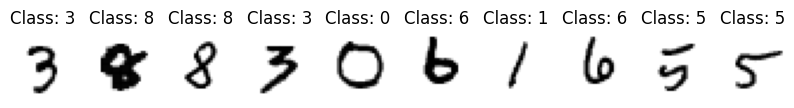

In [4]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title(f"Class: {y_train[i].item()}")

## Multilayer perceptron (MLP) network

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

In [5]:
# Define the model as an MLP with two hidden layers of size 50 and ReLU activations.
# Read more about the different types of layers here: http://pytorch.org/docs/nn.html
# We also add dropout layers to prevent overfitting.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 50)  # 28*28 is the size of the input image
        self.fc1_drop = nn.Dropout(0.2)  # Dropout layers help prevent overfitting

        self.fc2 = nn.Linear(50, 50)  # 50 is the size of the hidden layer
        self.fc2_drop = nn.Dropout(0.2)  # Dropout layers help prevent overfitting

        self.fc3 = nn.Linear(50, 10)  # 10 is the size of the output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image

        x = F.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = self.fc1_drop(x)  # Apply dropout to the first layer

        x = F.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.fc2_drop(x)  # Apply dropout to the second layer

        # Apply log softmax to the output layer to get a probability distribution
        # over the 10 classes of digits
        return F.log_softmax(self.fc3(x), dim=1)


# We instantiate the model and move it to the GPU if available.
model = Net().to(device)

# We use Stachastic Gradient Descent (SGD) as our optimizer and Cross Entropy as our loss function.
# See http://pytorch.org/docs/optim.html#algorithms for more information about the different optimization
# algorithms PyTorch offers.

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss_fn = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc25): Linear(in_features=50, out_features=50, bias=True)
  (fc25_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [6]:
def train(training_loss_values, epoch, log_interval=200):
    model.train()  # Set model to training mode
    val_loss = 0
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)  # Copy data to GPU if needed
        target = target.to(device)  # Copy target to GPU if needed

        # Run an optimization step. See https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step
        optimizer.zero_grad()  # Zero out gradients from previous step
        output = model(data)  # Pass data through the network
        loss = loss_fn(output, target)  # Calculate loss
        val_loss = loss.data.item()  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.data.item(),
                )
            )
    val_loss /= len(train_loader)  # Calculate average loss
    training_loss_values.append(val_loss)  # Add to loss vector


def validate(loss_vector, accuracy_vector):
    model.eval()  # Set model to evaluation mode
    val_loss, correct = (
        0,
        0,
    )  # Initialize loss and number of correct classifications to 0
    for data, target in validation_loader:
        data = data.to(device)  # Copy data to GPU if needed
        target = target.to(device)  # Copy target to GPU if needed
        output = model(data)  # Pass data through the network
        val_loss += loss_fn(output, target).data.item()  # Calculate loss
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += (
            pred.eq(target.data).cpu().sum()
        )  # Add number of correct classifications

    val_loss /= len(validation_loader)  # Calculate average loss
    loss_vector.append(val_loss)  # Add to loss vector

    accuracy = (
        100.0 * correct.to(torch.float32) / len(validation_loader.dataset)
    )  # Calculate accuracy
    accuracy_vector.append(accuracy)  # Add to accuracy vector

    print(
        "\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            val_loss, correct, len(validation_loader.dataset), accuracy
        )
    )

We will now train our model for 10 epochs and afterwards plot the training and validation losses over the training epochs. An epoch is a single pass through the training data.


In [7]:
%%time
epochs = 10

training_loss_values, loss_values, accuracy_values = [], [], []
for epoch in range(1, epochs + 1):
    train(training_loss_values, epoch)
    validate(loss_values, accuracy_values)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318963
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.306126
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.282050
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.273735
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.261850
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.156031
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.928202
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.754477
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.527291
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.335593

Validation set: Average loss: 0.9970, Accuracy: 7404/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.339798
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.057404
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.110222
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.139779
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.246039
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.673521
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.947093
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.635098
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.73

We now plot the training and validation losses over the training epochs.

Loss is a measure of how far a model's predictions are from its label, i.e. how bad the model is. The goal of training a model is to find a set of parameters that minimizes the loss. The loss is calculated using a loss function, which takes the model's prediction and the correct label as input and returns a number. The lower the loss, the better the model.

The training process tries to find the set of parameters that minimizes the loss on the training data, i.e. the training loss. However, we also want to know how well the model performs on data it has never seen before, i.e. the validation data. If the model performs much worse on the validation data than the training data, it is memorizing patterns in the training data rather than learning general rules that apply to data in general. This is called overfitting.

Text(0.5, 1.0, 'validation accuracy')

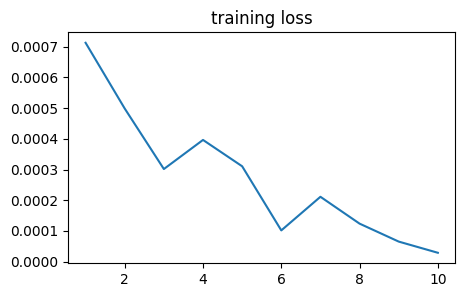

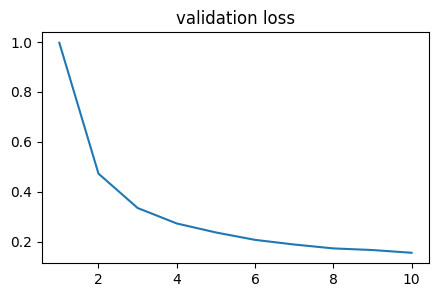

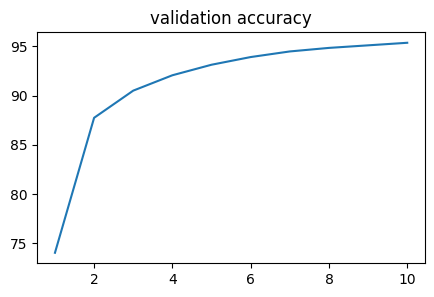

In [8]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), training_loss_values)
plt.title("training loss")

plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), loss_values)
plt.title("validation loss")

plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), accuracy_values)
plt.title("validation accuracy")

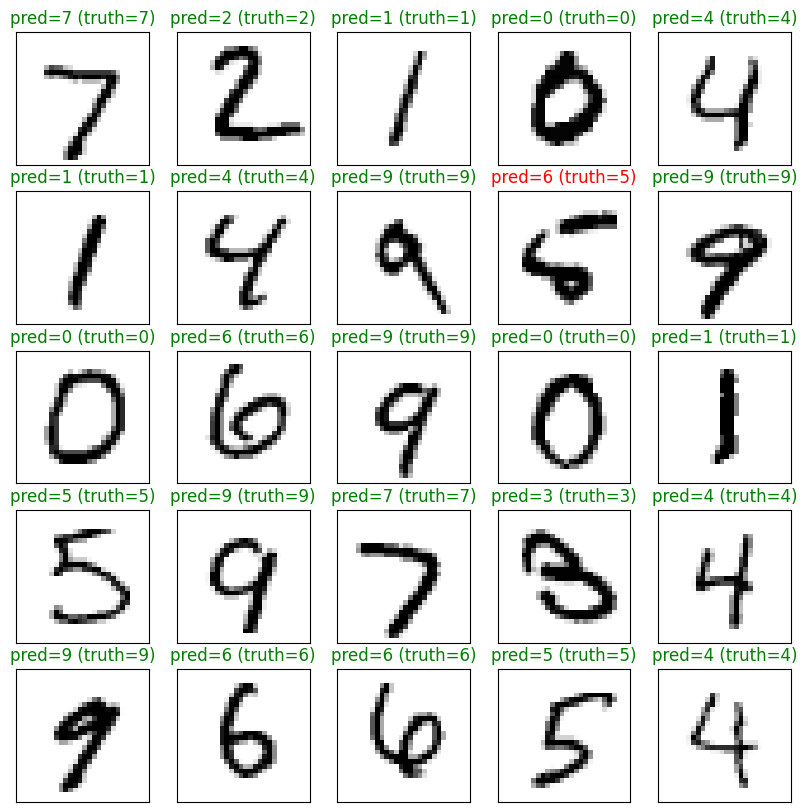

In [9]:
# Show model predictions and the true labels for a few images

model.eval()  # Set the model to evaluation mode
data, label = next(
    iter(validation_loader)
)  # Get a batch of validation data (batch size = 32)
data = data.to(device)  # Send data to device
output = model(data)  # Pass data through the network
pred = output.data.max(1)[
    1
]  # get the index of the max log-probability for each element in the batch

# Create a 5x5 grid and show the predicted and true labels for each of 25 images
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx + 1, xticks=[], yticks=[])
    ax.imshow(data[idx].cpu().numpy().reshape(28, 28), cmap="gray_r")
    ax.set_title(
        "pred={} (truth={})".format(str(pred[idx].item()), str(label[idx].item())),
        color=("green" if pred[idx] == label[idx] else "red"),
    )

## Model tuning

Modify the MLP model. Try to improve the classification accuracy, or experiment with the effects of different parameters.

First try changing the learning rate `lr` for the optimizer and run the notebook again.

Did you increase or decrease the learning rate? What was the effect on the training and validation losses? Try the opposite and see what happens.

Next, try adding an additional hidden layer to the MLP model. How does this affect the training and validation losses?

Finally, try changing the number of hidden units a the hidden layer. How does this affect the training and validation losses?

You can also consult the PyTorch documentation at http://pytorch.org/.